# TEMP_loom_load

In [1]:
# Libraries


# For loading the loom file
import anndata
import loompy
#import scanpy

# Floor and various functions
import math

# Histograms
import matplotlib.pyplot as plt

In [2]:
# Load the data.
cells = anndata.io.read_loom(
    "/media/aeneas/Samsung_T5/transfer/mayur/loom/BMP-1ST2.loom"
)

/home/aeneas/miniconda3/envs/3d_rna_velocity/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [3]:
cells

AnnData object with n_obs × n_vars = 13234 × 61860
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [4]:
# cells.layers['ambiguous'][68, 10131]

TODO: above cell is *minimum* keys for our package.

TODO: See which genes have isoforms...?

appears that the annotation uses just the canonical isoform, but engine should allow isoform fits.

In [5]:
test = [str(i) for i in list(cells.var['Accession'].index)]

In [6]:
for i in test:
    if i[0:3] == 'TET':
        print(i)

TET1
TET1P1
TET3
TET2-AS1
TET2


# CHECK

In [7]:
# Get (cell number, gene index) of spliced, unspliced, and ambiguous genes.

# Spliced genes.
spliced = []

# Row and column indices.
nonzeros = cells.layers['spliced'].nonzero()

row_indices = list(nonzeros[0])
column_indices = list(nonzeros[1])

for i in range(len(row_indices)):
    spliced.append((row_indices[i], column_indices[i]))

# Unspliced genes.
unspliced = []

# Row and column indices.
nonzeros = cells.layers['unspliced'].nonzero()

row_indices = list(nonzeros[0])
column_indices = list(nonzeros[1])
#print(row_indices)

for i in range(len(row_indices)):
    unspliced.append((row_indices[i], column_indices[i]))

# Ambiguous genes.
ambiguous = []

# Row and column indices.
nonzeros = cells.layers['ambiguous'].nonzero()

row_indices = list(nonzeros[0])
column_indices = list(nonzeros[1])
#print(row_indices)

for i in range(len(row_indices)):
    ambiguous.append((row_indices[i], column_indices[i]))

In [8]:
# set.intersection(set.intersection(set(spliced), set(unspliced)), set(ambiguous))

In [9]:
print(len(set(spliced)) == len(spliced))
print(len(set(unspliced)) == len(unspliced))
print(len(set(ambiguous)) == len(ambiguous))

True
True
True


# METRIC

We want to see if the probability of an unspliced molecule depends on the gene length (see Gorin G, Pachter L. Length Biases in Single-Cell RNA Sequencing of pre-mRNA. bioRxiv: 2021.07.30.454514; 2021.)  We begin by getting all gene lengths.

In [19]:
# Gene lengths.
gene_lengths_end = list(cells.var['End'])
gene_lengths_begin = list(cells.var['Start'])
gene_lengths = []

for i in range(0, len(gene_lengths_end)):

    # Log gene length.
    gene_lengths.append(math.log(abs(gene_lengths_end[i] - gene_lengths_begin[i])))

Now get all expressed gene lengths.

(array([  30.,  119.,  336.,  891., 2024., 3606., 3890., 2267.,  697.,
         111.]),
 array([ 4.24849524,  5.29576173,  6.34302821,  7.39029469,  8.43756117,
         9.48482766, 10.53209414, 11.57936062, 12.62662711, 13.67389359,
        14.72116007]),
 <BarContainer object of 10 artists>)

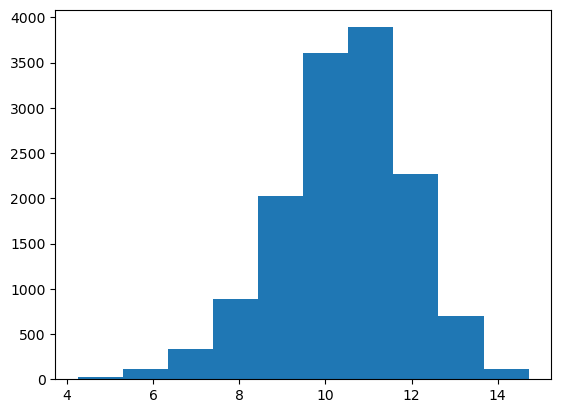

In [20]:
# All expressed gene indices.
all_expressed_genes_indices = [int(i[1]) for i in unspliced]
all_expressed_genes_indices += [int(i[1]) for i in spliced]
all_expressed_genes_indices += [int(i[1]) for i in ambiguous]
all_expressed_genes_indices = list(set(all_expressed_genes_indices))

expressed_gene_lengths = [gene_lengths[i] for i in all_expressed_genes_indices]

import math

histo = plt.hist(
    [i for i in expressed_gene_lengths]
    # bins = list(range(min_gene_length, max_gene_length, math.floor((max_gene_length-min_gene_length)/100)))
)

histo

We will need the bins and probabilities from the histogram.

In [21]:
# Lists easier to work with...
histo_list_bins = [i for i in reversed(list(histo[1]))]
histo_list_counts = [i for i in reversed(list(histo[0]))]

# Histogram bins.
bin_cutoffs = []
bin_probabilities = []

for i in histo_list_bins[1:]:
    bin_cutoffs.append(i)

# Basically CDF...
for i in range(0, len(histo_list_counts)):
    bin_probabilities.append(sum(histo_list_counts[0:(i + 1)])/sum(histo_list_counts))

In [22]:
bin_cutoffs

[13.673893589345194,
 12.626627106312323,
 11.579360623279452,
 10.532094140246581,
 9.48482765721371,
 8.437561174180841,
 7.390294691147971,
 6.343028208115101,
 5.2957617250822295,
 4.248495242049359]

In [25]:
# bin_probabilities

bin_cutoffs are essentially the "long" gene cutoffs we will use.  We need to also define a tolerance for how far apart the proportions of long genes can be between unspliced and spliced.

In [45]:
# The tolerance to say that unspliced and spliced 
# have the same ratio of "long" genes.
# tolerance = 0.3

TODO: easier to do all this on the sparsematrix object?

Now we go cell by cell and determine the proportion of "long" genes in the unspliced and spliced portions.  Start by converting gene indices to gene lengths for each cell.

In [31]:
# Get the gene lengths for each cell.
unspliced_lengths_by_cell = []
spliced_lengths_by_cell = []
ambiguous_lengths_by_cell = []

for i in unspliced:
    unspliced_lengths_by_cell.append((i[0], gene_lengths[i[1]]))

for i in spliced:
    spliced_lengths_by_cell.append((i[0], gene_lengths[i[1]]))

for i in ambiguous:
    ambiguous_lengths_by_cell.append((i[0], gene_lengths[i[1]]))

Let's make a dictionary, which is easier to parse, that contains cell and gene length information.

In [43]:
# Helper dictionary, with structure
# cell_number: [unspliced/spliced/ambiguous]: gene_length
cell_info = {}

for i in unspliced_lengths_by_cell:

    # What is the cell ID?
    cell_id = i[0]

    # Does the cell ID exist?
    if cell_id not in cell_info:
        cell_info[cell_id] = {}
        cell_info[cell_id]['unspliced'] = []

    # What are the lengths?
    cell_info[cell_id]['unspliced'].append(i[1])

for i in spliced_lengths_by_cell:

    # What is the cell ID?
    cell_id = i[0]

    # Does the cell ID exist?
    if cell_id not in cell_info:
        cell_info[cell_id] = {}
        cell_info[cell_id]['spliced'] = []
    else:
        cell_info[cell_id]['spliced'] = []

    # What are the lengths?
    cell_info[cell_id]['spliced'].append(i[1])

for i in ambiguous_lengths_by_cell:

    # What is the cell ID?
    cell_id = i[0]

    # Does the cell ID exist?
    if cell_id not in cell_info:
        cell_info[cell_id] = {}
        cell_info[cell_id]['ambiguous'] = []
    else:
        cell_info[cell_id]['ambiguous'] = []

    # What are the lengths?
    cell_info[cell_id]['ambiguous'].append(i[1])

In [44]:
cell_info

{1: {'unspliced': [11.25848472629825], 'spliced': [10.823869902313536]},
 2: {'unspliced': [11.888329911593228], 'spliced': [7.919356190660617]},
 4: {'unspliced': [11.580341093262826, 12.390213379949987],
  'spliced': [10.531909527867445]},
 8: {'unspliced': [10.870186186954129,
   9.207636720401869,
   11.969096361584823,
   12.621930230954774,
   12.864209038750309,
   13.775836862229873,
   10.867177004780158,
   12.390354779136763,
   10.25558704504304,
   9.558600006313569,
   11.21969469358803],
  'spliced': [7.587310506022615],
  'ambiguous': [10.23580832660629]},
 10: {'unspliced': [10.352650515910012], 'spliced': [8.31898612539206]},
 11: {'unspliced': [12.977145679423018, 12.090527104813981],
  'spliced': [8.385032287813898],
  'ambiguous': [9.085683767376628]},
 12: {'unspliced': [11.068246443685663], 'spliced': [11.14309290949077]},
 16: {'unspliced': [11.661897042082629],
  'spliced': [7.340186835320115],
  'ambiguous': [11.44001062690271]},
 29: {'unspliced': [10.0329795

Now go over each "long" gene cutoff and estimate the proportions.

In [46]:
# A dictionary to hold the results.
long_gene_results = {}

# Go over every cutoff for a "long" gene.
for long_gene_cutoff in bin_cutoffs:

    # Define the cutoff in the results.
    long_gene_results[long_gene_cutoff] = {
        'phat_unspliced': 0,
        'phat_spliced': 0
    }

    # Go over every cell expressing a gene and get
    # the probability of "long" gene expression
    # in the unspliced and spliced populations.
    
    # One time assuming "ambiguous" is spliced,
    # and one time assuming "ambiguous" is unspliced.
    for cn in cell_info.keys():

        # Get the cell info.
        temp_cell_info = cell_info[cn]

        # If "ambiguous" is available, add it to
        # unspliced.
        temp_cell_info['unspliced'] += temp_cell_info['ambiguous']

        print(temp_cell_info)
        print(x)

{'unspliced': [11.25848472629825], 'spliced': [10.823869902313536]}


NameError: name 'x' is not defined

In [27]:
spliced

[(0, 4649),
 (0, 19242),
 (0, 25457),
 (0, 30137),
 (0, 31235),
 (0, 33339),
 (0, 53346),
 (1, 4568),
 (2, 31237),
 (4, 12663),
 (4, 50867),
 (5, 52915),
 (8, 1753),
 (8, 3151),
 (8, 3198),
 (8, 3253),
 (8, 3291),
 (8, 3507),
 (8, 4147),
 (8, 5335),
 (8, 7823),
 (8, 8748),
 (8, 12173),
 (8, 12334),
 (8, 12663),
 (8, 14810),
 (8, 16289),
 (8, 20109),
 (8, 20604),
 (8, 23113),
 (8, 23248),
 (8, 25356),
 (8, 26187),
 (8, 26601),
 (8, 26890),
 (8, 27636),
 (8, 28367),
 (8, 28579),
 (8, 30137),
 (8, 31276),
 (8, 32054),
 (8, 32517),
 (8, 32611),
 (8, 33099),
 (8, 33339),
 (8, 35753),
 (8, 37096),
 (8, 37367),
 (8, 37895),
 (8, 40546),
 (8, 40778),
 (8, 41818),
 (8, 43812),
 (8, 45369),
 (8, 45797),
 (8, 48193),
 (8, 50321),
 (8, 50470),
 (8, 52995),
 (8, 53223),
 (8, 53480),
 (8, 57565),
 (8, 58577),
 (8, 58850),
 (8, 58852),
 (8, 60854),
 (9, 2328),
 (9, 10593),
 (9, 23883),
 (9, 55330),
 (10, 31436),
 (10, 48903),
 (10, 57374),
 (11, 10593),
 (11, 11969),
 (11, 12663),
 (11, 25457),
 (11,

# OLD

Now go cell by cell and see how many genes are "long" within the unspliced genes.

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



We begin by finding all expressed gene lengths (our "population").

In [9]:
# Gene population indices.
gene_population_indices = []

# Get the index of any expressed gene.
for j in [i[1] for i in unspliced]:
    gene_population_indices.append(j)

for j in [i[1] for i in spliced]:
    gene_population_indices.append(j)

for j in [i[1] for i in ambiguous]:
    gene_population_indices.append(j)

# Now get the lengths.
gene_population_lengths = []

for j in gene_population_indices:
    gene_population_lengths.append(gene_lengths[j])

NameError: name 'gene_lengths' is not defined

# METRIC

### We can consider how related the reads are to the gene length/number of isoforms.  If we see a reasonable trend relating the gene length to the splicing state, then we may have confounding (paper source...)

Get the spliced genes lengths.

In [40]:
# Spliced gene lengths.
spliced_gene_lengths = []

for j in [i[1] for i in spliced]:
    spliced_gene_lengths.append(gene_lengths[j])

Create bins for gene lengths, then see how many spliced genes are seen at a given gene length.

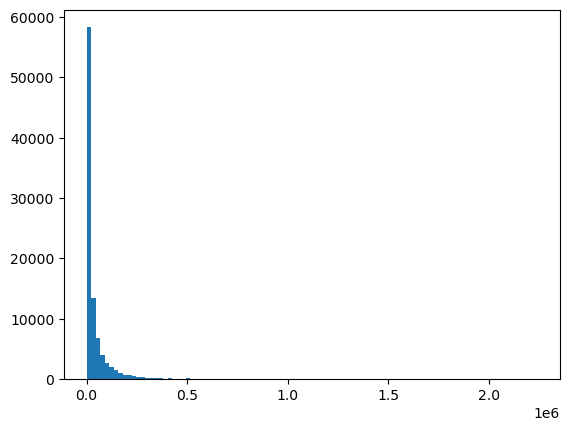

In [41]:
# Gene length bins.
min_gene_length = min(spliced_gene_lengths)
max_gene_length = max(spliced_gene_lengths)

# range(min_gene_length, max_gene_length, math.floor((max_gene_length-min_gene_length)/100))

plt.hist(
    spliced_gene_lengths,
    bins = list(range(min_gene_length, max_gene_length, math.floor((max_gene_length-min_gene_length)/100)))
)
plt.show()

In [ ]:
We can estimate the probability of success at each bin size